<a href="https://colab.research.google.com/github/EmmanuelJhno/Reinforcement_learning/blob/master/TP3_2020v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP3: Model Free

### Description: 

In this session, we are exploring a simple version of a game
(simpler version of Perudo: https://www.youtube.com/watch?v=die0n-eonl8).
Using the rules of the game, we first construct an environment. 
  
There is below a simple code where the game is played using a random statregy.

Also, there are two functions to display the optimal value functions and optimal policies.


### TO DO:

1) Implement MC, SARSA, Q-learning to learn the value function. It is recommended to use the indications of code below.


2) For the 3 cases, display the value function and the optimal policy found. 

3) Create a new environment which takes as parameter a given policy. Then implement iterations where you find the optimal value function for a given adversarial policy and then you play in turn against this policy.
Display the results after some iterations. Comment.

In [0]:
from IPython.display import Image
from IPython.core.display import HTML 


In [0]:
import gym
import numpy as np
import random
from gym import spaces
from gym.utils import seeding

THE GAME

**Rules**:

- 2 players 
- Each player has 5 coins (head or tail). Each player only sees her coins.  
- After flipping each coin, the game starts.
- The game consists in guessing how many heads are present between all coins (or make the other player guess wrongly).
- Bets start at 0 head.
- The starting player is chosen at random. (Flip a coin)
- Possible actions:
    * the player keeps the actual bet and passes.
    * the player add 1 to the actual bet (estimate of the total number of heads).
- The game stops when one player passes.
- if the bet is strictly bigger than the real number, the last player to play looses (r=-1) and the other wins (r=1). if the bet is smaller or equal, the last player wins (r=1) and the other looses (r=-1).
- IA initialisation of the computer strategy: if the bet  is smaller than 2+ quantity of observed own heads, bets, otherwise passes.

In [0]:
# Environment and rules

def throw_coin(num_coin, np_random):
    return np_random.rand(num_coin)>0.5

def total_faces(list_players):
    RV=0
    for player in list_players:
        RV += sum(player)
    return RV

class PerudoSimplified(gym.Env):
    def __init__(self):
        
        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(5), #my coins
            spaces.Discrete(10))) #actual priority

        self.seed()
        # Reset the game
        self.reset()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action)
        
        max_guess_player_2 = total_faces([self.player_2]) + int(len(self.player_1)/2) # The expectancy of the number of coins for the other player
        faces_tot = total_faces([self.player_1, self.player_2])
        
        if self.guess > len(self.player_1) + len(self.player_2): #the bet is bigger than the max possible
            done = True
            reward = -1

        if action == 0: # maintain the bet and pass 
            done = True
            if self.guess <= faces_tot: #the other player was right
                reward = -1
            else: #I was right
                reward = 1
            
        else: # add 1 in the bet 
            self.guess += 1
            if self.guess < max_guess_player_2: # the other player adds 1
                self.guess += 1 
                done = False
                reward = 0
            else: # other player passes
                done = True
                if self.guess <= faces_tot: 
                    reward = 1
                else:
                    reward = -1
            
        return self.get_obs(), reward, done, {}

    def get_obs(self):
        return (sum(self.player_1), self.guess)
    
    def reset(self):
        self.player_1 = throw_coin(5,self.np_random)
        self.player_2 = throw_coin(5,self.np_random)
        self.guess = 1 if np.random.rand()>0.5 else 0 # flip a coin to know who starts.
        return self.get_obs()

## Playing at random

In [4]:
env = PerudoSimplified()
print(env.observation_space)
print(env.action_space)

Tuple(Discrete(5), Discrete(10))
Discrete(2)


In [5]:
#Random Policy:
for i_episode in range(5):
    state = env.reset()
    while True:
        action = env.action_space.sample() # Selects a random action 
        state, reward, done, info = env.step(action) # Plays one round
        print(state,action)
        if done:
            print('Game over! Your reward: ', reward)
            print('You win :)\n') if reward > 0 else print('You lost:(\n')
            break

(1, 0) 0
Game over! Your reward:  -1
You lost:(

(4, 0) 0
Game over! Your reward:  -1
You lost:(

(2, 2) 1
(2, 4) 1
(2, 4) 0
Game over! Your reward:  -1
You lost:(

(2, 2) 1
(2, 2) 0
Game over! Your reward:  -1
You lost:(

(0, 0) 0
Game over! Your reward:  -1
You lost:(



## Graphs:

In [0]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_values(V):
    """
    Does a 3D display of the value function.
        
    The parameter V describes the value function in function of the number of "heads in your hand"
    and "actual bet".
    """
    def get_Z(x, y):
        if (x,y) in V:
            return V[x,y]
        else:
            return 0

    def get_figure(ax):
        x_range = np.arange(0, 6)
        y_range = np.arange(1, 11)
        X, Y = np.meshgrid(x_range, y_range)
        
        Z = np.array([get_Z(x,y) for x,y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)

        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('heads')
        ax.set_ylabel('bets')
        ax.set_zlabel('value')
        ax.view_init(ax.elev, -120)
    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(211, projection='3d')
    get_figure(ax)
    plt.show()

In [0]:
def plot_policy(policy):
    """
    3D graphic of value function.
    
     policy is a function of "heads" 
     and "bets" and the value is the action to be realized.
    """
    def get_Z(x, y):
        if (x,y) in policy:
            return policy[x,y]
        else:
            return 25 # this value is to vizualize that there is no action yet defined for this state
             

    def get_figure(ax):
        x_range = np.arange(0, 6)
        y_range = np.arange(0, 11)
        X, Y = np.meshgrid(x_range, y_range)
        Z = np.array([[get_Z(x,y) for x in x_range] for y in y_range])
        surf = ax.imshow(np.flip(Z,0), cmap=plt.get_cmap('Pastel2', 3), vmin=0, vmax=2, extent=[-0.5, 5.5, -0.5, 10.5])
        plt.xticks(x_range)
        plt.yticks(y_range)
        plt.gca().invert_yaxis()
        ax.set_xlabel('heads')
        ax.set_ylabel('bets')
        ax.grid(color='w', linestyle='-', linewidth=1)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(surf, ticks=[0,1,2], cax=cax)
        cbar.ax.set_yticklabels(['0 (pass)','1 (up)', 'unknown'])
        print(Z)
            
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111)
    get_figure(ax)
    plt.show()

## Monte Carlo

In [0]:
def get_probs(Q_s, epsilon, nA): 
    greedy = env.np_random.rand()
    if greedy<epsilon:
      policy_s = env.np_random.randint(nA) # Selects a random action 
    else:
      #exp_Q_array = np.exp(np.array(Q_s))
      #prob_Q = exp_Q_array/np.sum(exp_Q_array) # the softmax operation to get a probability to sample each action given their potential reward
      #sample = np.random.multinomial(1,Q_s) # np.random.multinomial(1,[0.2,0.5,0.3]) -> [0,1,0] or whatever according to a multinoulli
      sample = Q_s
      policy_s = np.argmax(sample)
    return policy_s
  

def generate_episode_from_policy(env, Q, epsilon, nA):
    episode = []
    state = env.reset()
    done = False
    while not done: # play an episode until the end
        action = get_probs(Q[state], epsilon, nA) # Select a 'learned' action from Q 
        state, reward, done, info = env.step(action) # Plays one round and get new state and reward
        episode.append((state,action))
    # Now the reward isn't 0 and we can save it
    episode.append(reward)
    return episode


def update_Q(env, episode, Q, alpha, gamma):
    reward = episode[-1]
    episode = episode[:-1]
    memory = 0
    for (state,action) in episode[::-1]: # reverse approach
      Q[state][action] += alpha * (reward + gamma*memory - Q[state][action])
      memory = Q[state][action]
    return Q

In [0]:
def mc_control(env, num_episodes, alpha, gamma=1.0, eps_start=1.0, eps_decay=.99999, eps_min=0.05):
    win_count, lose_count = 0, 0
    batch_nb = 1
    # Initialization :
    epsilon = eps_start
    nA = 2
    Q = {(my_sum, guess): [0 for _ in range(nA)] for guess in range(11) for my_sum in range(6)}
    for i_episode in range(num_episodes):
      episode = generate_episode_from_policy(env, Q, epsilon, nA)
      update_Q(env, episode, Q, alpha, gamma)

      epsilon = max(epsilon * eps_decay, eps_min)

      if episode[-1] > 0:
        win_count += 1
      else:
        lose_count += 1

      if (i_episode+1)%(num_episodes//10)==0:
        print('Batch #{} : You won {} times | You lost {} times \t-> score = {:.1f}%'.format(batch_nb, win_count, lose_count,
                                                                                             100.*win_count/(win_count + lose_count)))
        win_count, lose_count = 0, 0
        batch_nb += 1

    policy = {}
    for state in Q.keys():
      policy[state] = np.argmax(Q[state])
    
    return policy, Q

Batch #1 : You won 10230 times | You lost 39770 times 	-> score = 20.5%
Batch #2 : You won 17760 times | You lost 32240 times 	-> score = 35.5%
Batch #3 : You won 23931 times | You lost 26069 times 	-> score = 47.9%
Batch #4 : You won 28386 times | You lost 21614 times 	-> score = 56.8%
Batch #5 : You won 31203 times | You lost 18797 times 	-> score = 62.4%
Batch #6 : You won 32981 times | You lost 17019 times 	-> score = 66.0%
Batch #7 : You won 33670 times | You lost 16330 times 	-> score = 67.3%
Batch #8 : You won 33654 times | You lost 16346 times 	-> score = 67.3%
Batch #9 : You won 33808 times | You lost 16192 times 	-> score = 67.6%
Batch #10 : You won 33739 times | You lost 16261 times 	-> score = 67.5%


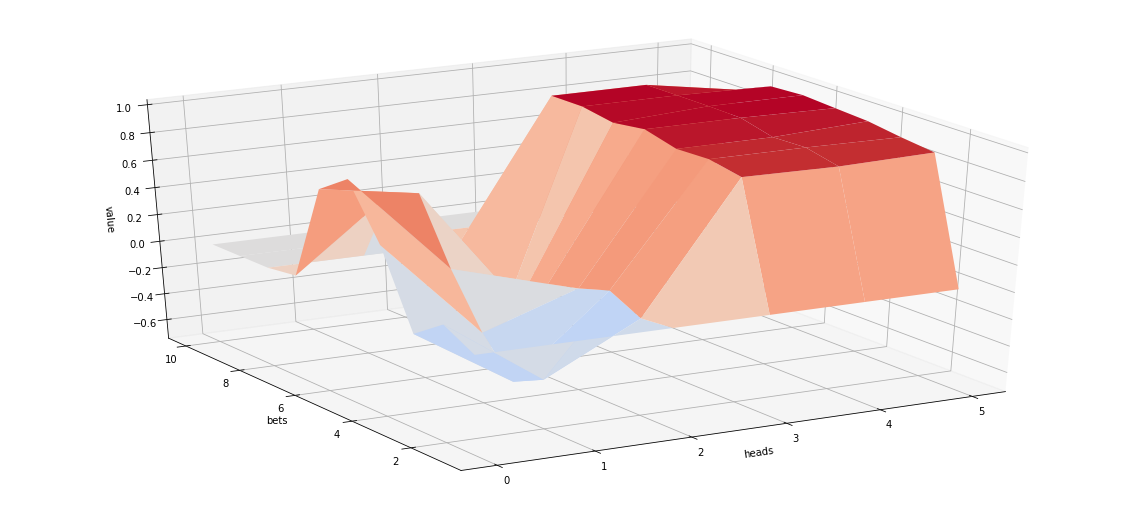

In [10]:
# Compute  the optimal policy and value function
policy, Q = mc_control(env=env, num_episodes=500_000, alpha=0.015, gamma=0)
V = dict((k,np.max(v)) for k, v in Q.items())
plot_values(V)

[[1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [0 1 1 1 1 1]
 [0 0 1 1 1 1]
 [0 0 1 1 1 1]
 [0 0 1 1 1 1]
 [0 0 1 1 1 1]
 [0 0 0 1 1 1]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]


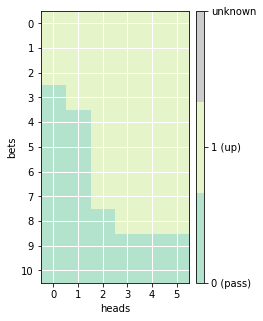

In [11]:
# plot the policy
plot_policy(policy)

## SARSA

In [0]:
def get_action_sarsa(Q_s, epsilon, nA): 
    # probability of 1-eps/2 to select the argmax, versus a probability of eps/2 to select the other one
    greedy = env.np_random.rand()
    action = np.argmax(Q_s)
    if greedy<(epsilon/2):
      action = 1 - action # Selects the other action (since there are only two of those, we can do it this way)
    return action

def generate_episode_from_policy_sarsa(env, Q, epsilons, nA):
    episode = []
    state = env.reset()
    done = False
    while not done: # play an episode until the end
        action = get_action_sarsa(Q[state], epsilons[state], nA) # Select a 'learned' action from Q 
        state, reward, done, info = env.step(action) # Plays one round and get new state and reward
        episode.append((state,action))
    # Now the reward isn't 0 and we can save it
    episode.append(reward)
    return episode

def update_Q_sarsa(alpha, gamma, Q, state, action, reward, epsilon, next_state=None, next_action=None):
    if next_state==None and next_action==None:
      next_step = 0
    else:
      next_step = (epsilon * Q[next_state][next_action] / 2) + ((1-epsilon) * Q[next_state][1-next_action] / 2)
    Q[state][action] += alpha * (reward + gamma*next_step - Q[state][action])
    return Q
    
def epsilon_greedy(epsilons, state, epsmin):
    # The more the state has been visited the more likely we are to be sure about our prediction
    epsilons[state] = max(epsmin, 1/(1+1/epsilons[state])) # since 1/epsilons[state] is the previous number of visits to state
    return epsilons

In [0]:
def sarsa(env, num_episodes, alpha, gamma=1.0, epsmin=0.01):
    win_count, lose_count = 0, 0
    batch_nb = 1
    # Initialization :
    epsilons = {(my_sum, guess): 1 for guess in range(11) for my_sum in range(6)}
    nA = 2
    Q = {(my_sum, guess): [0 for _ in range(nA)] for guess in range(11) for my_sum in range(6)}
    for i_episode in range(num_episodes):
      episode = generate_episode_from_policy_sarsa(env, Q, epsilons, nA)
      
      reward = episode[-1] # the reward is constant for this game
      episode = episode[:-1]
      next_state, next_action = None, None
      for (state,action) in episode[::-1]: # reverse approach to consider the next state and action to update Q
        Q = update_Q_sarsa(alpha, gamma, Q, state, action, reward, epsilons[state], next_state, next_action)
        next_state, next_action = state, action

        epsilons = epsilon_greedy(epsilons, state, epsmin)
      
      if reward > 0:
        win_count += 1
      else:
        lose_count += 1

      if (i_episode+1)%(num_episodes//10)==0:
        print('Batch #{} : You won {} times | You lost {} times \t-> score = {:.1f}%'.format(batch_nb, win_count, lose_count,
                                                                                             100.*win_count/(win_count + lose_count)))
        win_count, lose_count = 0, 0
        batch_nb += 1

    return Q

Batch #1 : You won 22715 times | You lost 27285 times 	-> score = 45.4%
Batch #2 : You won 24266 times | You lost 25734 times 	-> score = 48.5%
Batch #3 : You won 24329 times | You lost 25671 times 	-> score = 48.7%
Batch #4 : You won 24408 times | You lost 25592 times 	-> score = 48.8%
Batch #5 : You won 24507 times | You lost 25493 times 	-> score = 49.0%
Batch #6 : You won 24699 times | You lost 25301 times 	-> score = 49.4%
Batch #7 : You won 24350 times | You lost 25650 times 	-> score = 48.7%
Batch #8 : You won 24642 times | You lost 25358 times 	-> score = 49.3%
Batch #9 : You won 25274 times | You lost 24726 times 	-> score = 50.5%
Batch #10 : You won 24801 times | You lost 25199 times 	-> score = 49.6%


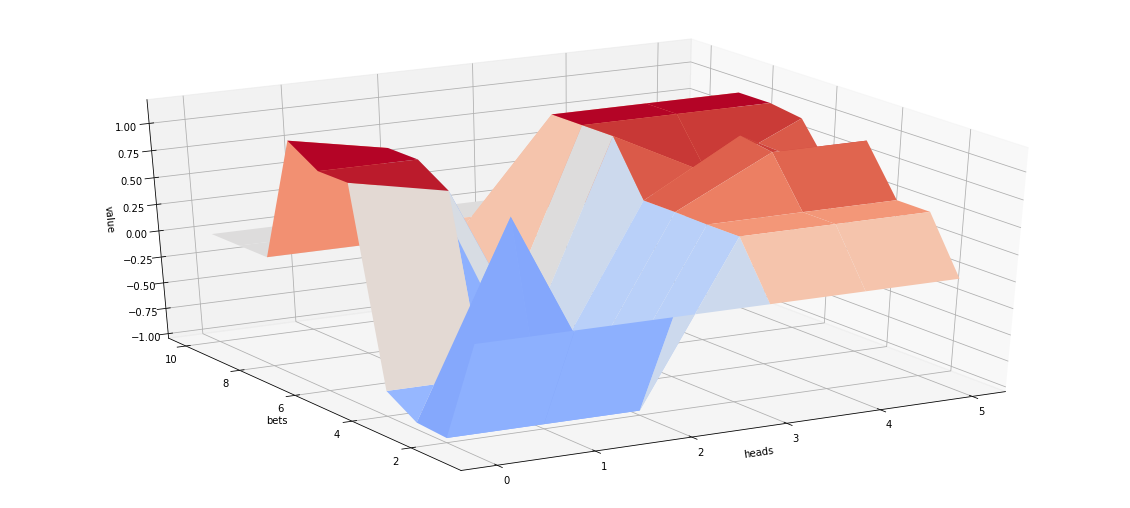

In [23]:
# Compute  the optimal policy and value function
Q_sarsa = sarsa(env, 500_000, 0.9)
V = dict((k,np.max(v)) for k, v in Q_sarsa.items())
plot_values(V)

[[1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [0 0 0 1 1 1]
 [0 0 0 1 1 1]
 [0 0 0 1 1 1]
 [0 0 0 1 1 1]
 [0 0 0 1 1 1]
 [1 0 1 1 1 1]
 [0 0 0 1 1 1]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]


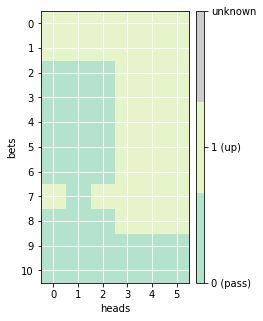

In [24]:
# plot
policy_sarsa = dict((k,np.argmax(v)) for k, v in Q_sarsa.items())
plot_policy(policy_sarsa)

## Q-learning

In [0]:
def update_Q_sarsamax(alpha, gamma, Q, state, action, reward, next_state=None):
    if next_state==None:
      next_step = 0
    else:
      next_step = np.max(np.array(Q[next_state]))
    Q[state][action] += alpha * (reward + gamma*next_step - Q[state][action])
    return Q

In [0]:
def q_learning(env, num_episodes, alpha, gamma=1.0, epsmin=0.01):
    win_count, lose_count = 0, 0
    batch_nb = 1
    # Initialization :
    epsilons = {(my_sum, guess): 1 for guess in range(11) for my_sum in range(6)}
    nA = 2
    Q = {(my_sum, guess): [0 for _ in range(nA)] for guess in range(11) for my_sum in range(6)}
    for i_episode in range(num_episodes):
      episode = generate_episode_from_policy_sarsa(env, Q, epsilons, nA)
      
      reward = episode[-1] # the reward is constant for this game
      episode = episode[:-1]
      next_state, next_action = None, None
      for (state,action) in episode[::-1]: # reverse approach to consider the next state and action to update Q
        Q = update_Q_sarsamax(alpha, gamma, Q, state, action, reward, next_state)
        next_state = state

        epsilons = epsilon_greedy(epsilons, state, epsmin)
      
      if reward > 0:
        win_count += 1
      else:
        lose_count += 1

      if (i_episode+1)%(num_episodes//10)==0:
        print('Batch #{} : You won {} times | You lost {} times \t-> score = {:.1f}%'.format(batch_nb, win_count, lose_count,
                                                                                             100.*win_count/(win_count + lose_count)))
        win_count, lose_count = 0, 0
        batch_nb += 1

    return Q

Batch #1 : You won 24354 times | You lost 25646 times 	-> score = 48.7%
Batch #2 : You won 25872 times | You lost 24128 times 	-> score = 51.7%
Batch #3 : You won 25920 times | You lost 24080 times 	-> score = 51.8%
Batch #4 : You won 25937 times | You lost 24063 times 	-> score = 51.9%
Batch #5 : You won 26048 times | You lost 23952 times 	-> score = 52.1%
Batch #6 : You won 25881 times | You lost 24119 times 	-> score = 51.8%
Batch #7 : You won 26128 times | You lost 23872 times 	-> score = 52.3%
Batch #8 : You won 26013 times | You lost 23987 times 	-> score = 52.0%
Batch #9 : You won 26011 times | You lost 23989 times 	-> score = 52.0%
Batch #10 : You won 26182 times | You lost 23818 times 	-> score = 52.4%


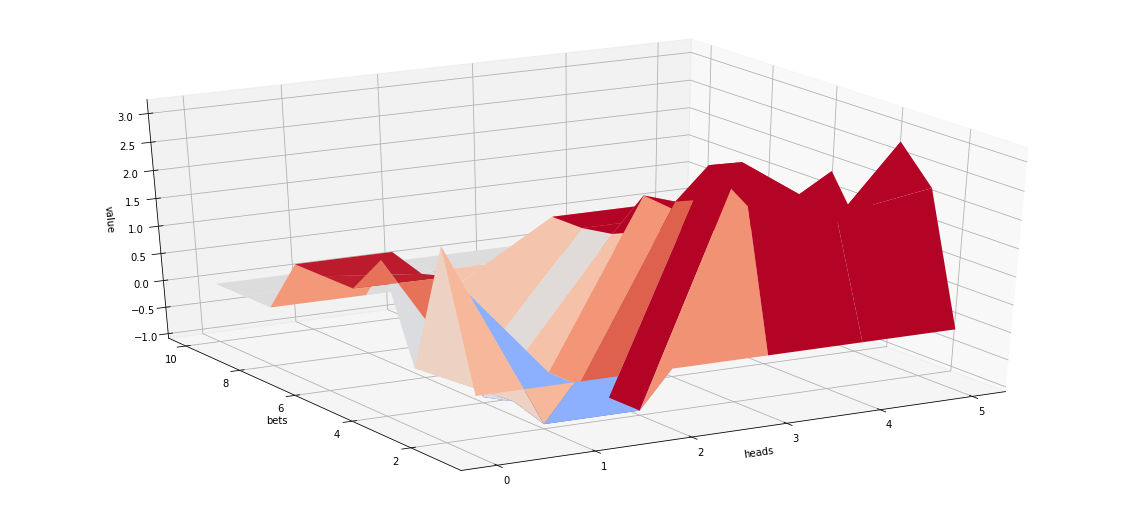

In [25]:
# Compute  the optimal policy and value function
Q_sarsamax = q_learning(env, 500_000, 0.9)
V = dict((k,np.max(v)) for k, v in Q_sarsamax.items())
plot_values(V)

[[1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [0 0 0 0 1 0]
 [1 0 0 0 1 1]
 [0 0 1 1 1 1]
 [1 0 1 1 1 1]
 [0 0 0 1 1 1]
 [0 0 0 1 1 1]
 [0 0 0 1 1 1]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]


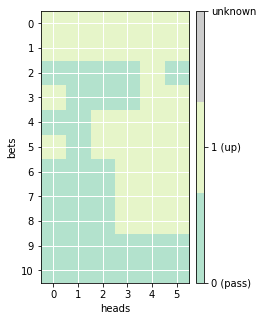

In [22]:
# plot
policy_sarsamax = dict((k,np.argmax(v)) for k, v in Q_sarsamax.items())
plot_policy(policy_sarsamax)